# Random Forest

In [1]:
%reload_ext autoreload
%autoreload 2

## Imports

In [2]:
import bz2
import os
import sys
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import scipy as sp
import seaborn as sns
from copy import copy
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

sys.path.append(os.path.abspath('../src'))
from fact_classification import *

2023-04-25 18:45:34.928842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load datafiles

In [3]:
df, df_crowdsourced, df_ground_truth = data_loading(local=True)
df['Sentiment'] = df.Sentiment.fillna(df.Sentiment[df.Verdict == -1].mean())

## Load features
Load the features matrix that we generated in the `feature_generation.ipynb` notebook. This is a large sparse matrix so ww convert it to Compressed Sparse Row (CSR) format to avoid running out of memory when fitting our models.

In [4]:
with bz2.open('../results/df_features.bz2') as f:
    df_features = pickle.load(f)

# Convert to compressed sparse row matrix
X = sp.sparse.csr_matrix(df_features)

## Split data and generate indexes

We split the dataset according to the instructions in the assignment, where data up until and including year 2008 will be used for training, and data after 2008 will be used for testing. Here we also generate indexes for the various feature sets.

In [5]:
df_train, df_test, idx_train = test_train_split(df)

y = df['Verdict']
y_train = df_train['Verdict']
y_test = df_test['Verdict']

X_train = X[idx_train]
X_test = X[~idx_train]

# Column index for the numeric columns Sentiment and Length
col_idx_n = (df_features.columns == 'Sentiment') | (df_features.columns == 'Length')

# Column index for TF-IDF features on the raw Text column with n-grams=1
col_idx_w1 = df_features.columns.str.startswith('W1_')

# Column index for TF-IDF features on the raw Text column with n-grams=2
col_idx_w2 = df_features.columns.str.startswith('W2_')

# Column index for TF-IDF features on the stemmed text with n-grams=1
col_idx_ws = df_features.columns.str.startswith('WS_')

# Column index for POS features
col_idx_p = df_features.columns.str.startswith('P_')

# Column index for NER labels
col_idx_e = df_features.columns.str.startswith('E_')

## Setup for GridSearchCV

We use GridSearchCV from scikit-learn to get the best combination of parameters for the model. Since we have an unbalanced dataset we set `class_weight='balanced_subsample'` for the RandomForestClassifier. This will ensure that we have a balanced distribution in the subtrees.

For the grid search we will test with 100, 500, and 1000 trees, and max depths of 5, 10, and 20. We limit the depth to avoid overfitting, and we limit the number of trees to reduce training time. Further, we use weighted f1-score for scoring the grid search, and we define a 4-fold cross validation.

In [6]:
rfc = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [5, 10, 20]
}

clf = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=4,
    n_jobs=10,
    return_train_score=True,
    verbose=0
)


## Define experiments

In [7]:
# Define experiments
experiments = {
    'N': col_idx_n,
    'W': col_idx_w1,
    'P': col_idx_p,
    'E': col_idx_e,
    'N_W': col_idx_n | col_idx_w1,
    'N_P': col_idx_n | col_idx_p,
    'N_E': col_idx_n | col_idx_e,
    'N_W_P': col_idx_n | col_idx_w1 | col_idx_p,
    'N_W_E': col_idx_n | col_idx_w1 | col_idx_e,
    'N_W_P_E': col_idx_n | col_idx_w1 | col_idx_p | col_idx_e
}


## Run experiments

In [8]:
df_score_train = pd.DataFrame()
df_score_test = pd.DataFrame()
models = {}

for features, index in experiments.items():
  exp_clf, exp_score_train, exp_score_test = run_experiment(
      clf=copy(clf),
      X_train=X_train[:, index],
      y_train=y_train,
      X_test=X_test[:, index],
      y_test=y_test,
      annotations={
        'algorithm': 'RF',
        'features': features}
  )
  models[features] = exp_clf
  # Print test results
  print('Test metrics:')
  display(exp_score_test)
  # Add results to dataframe
  df_score_train = pd.concat([df_score_train, exp_score_train]).reset_index(drop=True)
  df_score_test = pd.concat([df_score_test, exp_score_test]).reset_index(drop=True)

Running experiment with algorithm "RF" and features "N"
Best parameters found: {'max_depth': 20, 'n_estimators': 100}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RF,N,0.644,0.156,0.346,0.508,0.511,0.427,0.249,0.431,0.569,0.228,0.29,0.455


Running experiment with algorithm "RF" and features "W"
Best parameters found: {'max_depth': 20, 'n_estimators': 1000}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RF,W,0.79,0.295,0.657,0.697,0.814,0.459,0.45,0.676,0.802,0.36,0.534,0.679


Running experiment with algorithm "RF" and features "P"
Best parameters found: {'max_depth': 20, 'n_estimators': 1000}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RF,P,0.717,0.346,0.558,0.632,0.895,0.189,0.346,0.667,0.796,0.245,0.428,0.634


Running experiment with algorithm "RF" and features "E"
Best parameters found: {'max_depth': 5, 'n_estimators': 500}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RF,E,0.735,0.192,0.629,0.644,0.798,0.284,0.372,0.625,0.765,0.229,0.467,0.624


Running experiment with algorithm "RF" and features "N_W"
Best parameters found: {'max_depth': 20, 'n_estimators': 500}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RF,N_W,0.789,0.288,0.636,0.69,0.814,0.427,0.454,0.673,0.801,0.344,0.53,0.676


Running experiment with algorithm "RF" and features "N_P"
Best parameters found: {'max_depth': 20, 'n_estimators': 500}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RF,N_P,0.714,0.357,0.588,0.639,0.916,0.18,0.329,0.674,0.802,0.239,0.422,0.636


Running experiment with algorithm "RF" and features "N_E"
Best parameters found: {'max_depth': 10, 'n_estimators': 500}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RF,N_E,0.739,0.193,0.588,0.635,0.797,0.236,0.424,0.632,0.767,0.212,0.492,0.629


Running experiment with algorithm "RF" and features "N_W_P"
Best parameters found: {'max_depth': 20, 'n_estimators': 500}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RF,N_W_P,0.791,0.321,0.621,0.691,0.836,0.421,0.454,0.686,0.813,0.364,0.525,0.684


Running experiment with algorithm "RF" and features "N_W_E"
Best parameters found: {'max_depth': 20, 'n_estimators': 500}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RF,N_W_E,0.788,0.329,0.676,0.705,0.853,0.421,0.464,0.699,0.819,0.369,0.55,0.695


Running experiment with algorithm "RF" and features "N_W_P_E"
Best parameters found: {'max_depth': 20, 'n_estimators': 1000}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RF,N_W_P_E,0.793,0.322,0.664,0.704,0.844,0.419,0.479,0.697,0.818,0.364,0.557,0.696


# Results

Plot the weighted f1-scores for the training and testing datasets for each of the feature sets. The results are sorted by increading testing scores.

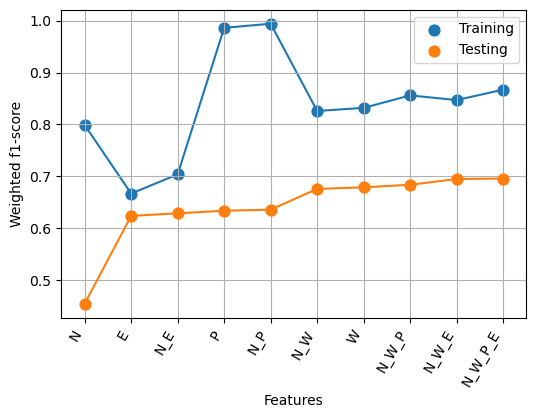

In [9]:
plot_train_test_score(df_score_train, df_score_test, method='RF', order_by='f_wavg')

Plot the training times from `GridSearchCV`, sorted by increasing mean.

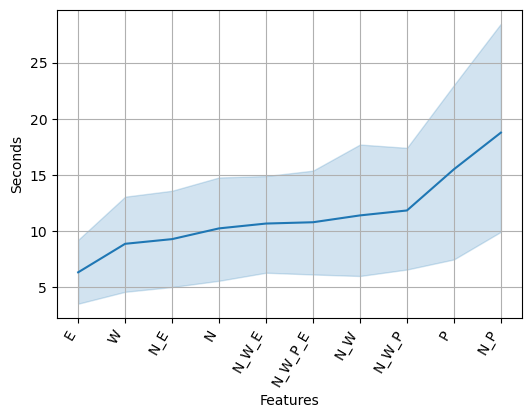

In [11]:
plot_train_time(models)

Plot ROC curve.

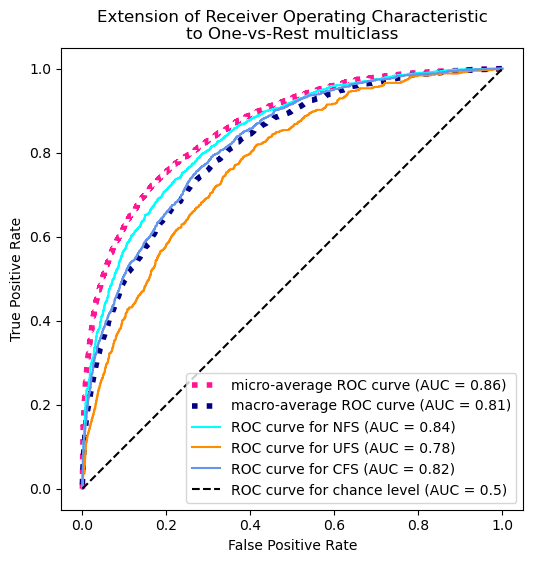

In [12]:
y_score = models['N_W_P_E'].best_estimator_.predict_proba(X_test[:, experiments['N_W_P_E']])
plot_roc_curve(y_test, y_score)

List all training and testing scores, sorted by increasing weighted f1-score.

In [13]:
print('Training metrics:')
display(df_score_train.sort_values(by='f_wavg'))

print('Testing metrics:')
display(df_score_test.sort_values(by='f_wavg'))

Training metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
3,RF,E,0.802,0.183,0.600,0.692,0.771,0.337,0.447,0.651,0.786,0.237,0.512,0.667
6,RF,N_E,0.819,0.302,0.586,0.712,0.781,0.385,0.593,0.697,0.799,0.338,0.589,0.704
0,RF,N,0.999,0.351,0.776,0.881,0.728,0.916,0.833,0.772,0.842,0.508,0.804,0.799
4,RF,N_W,0.936,0.517,0.737,0.847,0.826,0.847,0.781,0.818,0.878,0.642,0.758,0.826
1,RF,W,0.933,0.518,0.768,0.852,0.835,0.864,0.773,0.824,0.881,0.648,0.771,0.832
8,RF,N_W_E,0.926,0.580,0.783,0.858,0.869,0.840,0.768,0.843,0.897,0.686,0.775,0.847
7,RF,N_W_P,0.939,0.619,0.765,0.866,0.870,0.855,0.800,0.852,0.903,0.718,0.782,0.856
9,RF,N_W_P_E,0.937,0.622,0.809,0.876,0.885,0.866,0.800,0.863,0.910,0.724,0.805,0.867
2,RF,P,0.997,0.910,0.993,0.987,0.986,0.992,0.984,0.986,0.991,0.950,0.989,0.986
5,RF,N_P,0.999,0.954,0.998,0.994,0.994,0.999,0.993,0.994,0.997,0.976,0.995,0.994


Testing metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RF,N,0.644,0.156,0.346,0.508,0.511,0.427,0.249,0.431,0.569,0.228,0.290,0.455
3,RF,E,0.735,0.192,0.629,0.644,0.798,0.284,0.372,0.625,0.765,0.229,0.467,0.624
6,RF,N_E,0.739,0.193,0.588,0.635,0.797,0.236,0.424,0.632,0.767,0.212,0.492,0.629
2,RF,P,0.717,0.346,0.558,0.632,0.895,0.189,0.346,0.667,0.796,0.245,0.428,0.634
5,RF,N_P,0.714,0.357,0.588,0.639,0.916,0.180,0.329,0.674,0.802,0.239,0.422,0.636
4,RF,N_W,0.789,0.288,0.636,0.690,0.814,0.427,0.454,0.673,0.801,0.344,0.530,0.676
1,RF,W,0.790,0.295,0.657,0.697,0.814,0.459,0.450,0.676,0.802,0.360,0.534,0.679
7,RF,N_W_P,0.791,0.321,0.621,0.691,0.836,0.421,0.454,0.686,0.813,0.364,0.525,0.684
8,RF,N_W_E,0.788,0.329,0.676,0.705,0.853,0.421,0.464,0.699,0.819,0.369,0.550,0.695
9,RF,N_W_P_E,0.793,0.322,0.664,0.704,0.844,0.419,0.479,0.697,0.818,0.364,0.557,0.696


## Feature Importance

In [14]:
best_features = df_score_test.sort_values(by='f_wavg', ascending=False).reset_index().loc[0, 'features']
best_features_idx = experiments[best_features]
best_model = models[best_features].best_estimator_

In [15]:
# Average feature importance
df_feature_importance = pd.DataFrame(
    best_model.feature_importances_,
    index=df_features.columns[best_features_idx],
    columns=['Importance']
).sort_values('Importance', ascending=False)
df_feature_importance.head(10)

,Importance
P_VBD,0.041259
P_VB,0.033489
E_money,0.018991
Length,0.017113
P_NNP,0.016827
P_MD,0.016294
Sentiment,0.015852
P_PRP,0.015440
P_VBP,0.015078
W1_to,0.014206


In [16]:
# All feature importance for all trees
df_feature_all = pd.DataFrame(
    [tree.feature_importances_ for tree in best_model.estimators_],
    columns=df_features.columns[best_features_idx]
)
df_feature_all.head()

,Sentiment,Length,W1_00,W1_000,W1_10,W1_100,W1_1000,W1_101,W1_104,W1_105,...,E_money,E_norp,E_ordinal,E_org,E_percent,E_person,E_product,E_quantity,E_time,E_work_of_art
0,0.005702,0.016763,0.0,0.005518,0.000201,6.891737e-07,0.0,0.0,0.0,0.0,...,0.007611,0.001971,0.000145,0.001110,0.082810,0.028501,0.0,0.0,0.000246,0.0
1,0.006314,0.014582,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,...,0.053569,0.000000,0.000053,0.000113,0.003319,0.007027,0.0,0.0,0.003171,0.0
2,0.005219,0.005760,0.0,0.011758,0.000133,0.000000e+00,0.0,0.0,0.0,0.0,...,0.005070,0.000635,0.000688,0.000966,0.000000,0.006209,0.0,0.0,0.000000,0.0
3,0.015393,0.005905,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,...,0.008000,0.000451,0.000000,0.000946,0.130033,0.005137,0.0,0.0,0.000000,0.0
4,0.005163,0.033521,0.0,0.000630,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,...,0.090919,0.000000,0.001149,0.006863,0.000013,0.002710,0.0,0.0,0.000000,0.0


In [17]:
# Melt data to long format
df_feature_long = pd.melt(
    df_feature_all[df_feature_importance.head(30).index],
    var_name='Feature',
    value_name='Value'
)

### Plot feature importance

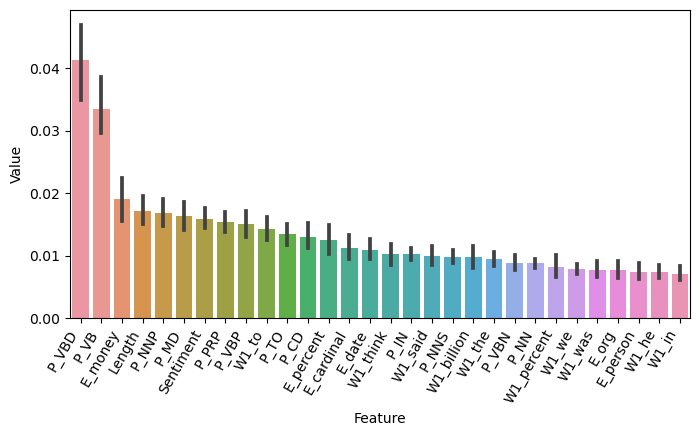

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=df_feature_long, x='Feature', y='Value', errorbar=('ci', 99.9), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
plt.show()

## Save results to file

In [19]:
# Save the scoring metrics to file
score_saving(df_score_train, df_score_test, fname='RandomForest_score')

# Save the trained models to file
with bz2.open('../models/RandomForest.bz2', 'wb') as f:
    pickle.dump(models, f)

## Export results to LaTeX

In [20]:
to_latex(df_score_train)

\begin{tabular}{llrrrrrrrrrrrr}
\toprule
algorithm & features & p\_NFS & p\_UFS & p\_CFS & p\_wavg & r\_NFS & r\_UFS & r\_CFS & r\_wavg & f\_NFS & f\_UFS & f\_CFS & f\_wavg \\
\midrule
RF & N & 0.999 & 0.351 & 0.776 & 0.881 & 0.728 & 0.916 & 0.833 & 0.772 & 0.842 & 0.508 & 0.804 & 0.799 \\
RF & W & 0.933 & 0.518 & 0.768 & 0.852 & 0.835 & 0.864 & 0.773 & 0.824 & 0.881 & 0.648 & 0.771 & 0.832 \\
RF & P & 0.997 & 0.910 & 0.993 & 0.987 & 0.986 & 0.992 & 0.984 & 0.986 & 0.991 & 0.950 & 0.989 & 0.986 \\
RF & E & 0.802 & 0.183 & 0.600 & 0.692 & 0.771 & 0.337 & 0.447 & 0.651 & 0.786 & 0.237 & 0.512 & 0.667 \\
RF & N\_W & 0.936 & 0.517 & 0.737 & 0.847 & 0.826 & 0.847 & 0.781 & 0.818 & 0.878 & 0.642 & 0.758 & 0.826 \\
RF & N\_P & 0.999 & 0.954 & 0.998 & 0.994 & 0.994 & 0.999 & 0.993 & 0.994 & 0.997 & 0.976 & 0.995 & 0.994 \\
RF & N\_E & 0.819 & 0.302 & 0.586 & 0.712 & 0.781 & 0.385 & 0.593 & 0.697 & 0.799 & 0.338 & 0.589 & 0.704 \\
RF & N\_W\_P & 0.939 & 0.619 & 0.765 & 0.866 & 0.870 & 0.855 & 0

In [21]:
to_latex(df_score_test)

\begin{tabular}{llrrrrrrrrrrrr}
\toprule
algorithm & features & p\_NFS & p\_UFS & p\_CFS & p\_wavg & r\_NFS & r\_UFS & r\_CFS & r\_wavg & f\_NFS & f\_UFS & f\_CFS & f\_wavg \\
\midrule
RF & N & 0.644 & 0.156 & 0.346 & 0.508 & 0.511 & 0.427 & 0.249 & 0.431 & 0.569 & 0.228 & 0.290 & 0.455 \\
RF & W & 0.790 & 0.295 & 0.657 & 0.697 & 0.814 & 0.459 & 0.450 & 0.676 & 0.802 & 0.360 & 0.534 & 0.679 \\
RF & P & 0.717 & 0.346 & 0.558 & 0.632 & 0.895 & 0.189 & 0.346 & 0.667 & 0.796 & 0.245 & 0.428 & 0.634 \\
RF & E & 0.735 & 0.192 & 0.629 & 0.644 & 0.798 & 0.284 & 0.372 & 0.625 & 0.765 & 0.229 & 0.467 & 0.624 \\
RF & N\_W & 0.789 & 0.288 & 0.636 & 0.690 & 0.814 & 0.427 & 0.454 & 0.673 & 0.801 & 0.344 & 0.530 & 0.676 \\
RF & N\_P & 0.714 & 0.357 & 0.588 & 0.639 & 0.916 & 0.180 & 0.329 & 0.674 & 0.802 & 0.239 & 0.422 & 0.636 \\
RF & N\_E & 0.739 & 0.193 & 0.588 & 0.635 & 0.797 & 0.236 & 0.424 & 0.632 & 0.767 & 0.212 & 0.492 & 0.629 \\
RF & N\_W\_P & 0.791 & 0.321 & 0.621 & 0.691 & 0.836 & 0.421 & 0